# Введение в хемоинформатику и дизайн лекарств



## 0. Импорты

In [1]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install dgllife
!pip install torch_geometric
!pip install --pre deepchem

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.2/884.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.4 MB/s eta 0:00:00


In [2]:
from IPython.display import display, clear_output

from scipy import sparse

from sklearn.metrics import roc_curve, roc_auc_score

import deepchem as dc
import torch

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [25]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. RDKit




RdKit - библиотека для работы с молекулами.

In [3]:
from rdkit import Chem

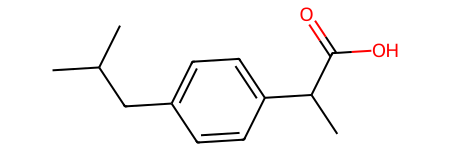

In [4]:
ibu=Chem.MolFromSmiles('CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')

display(ibu)

In [ ]:
# можно сделать итерацию по атомам молекулы
for atom in ibu.GetAtoms():
    print(atom.GetAtomicNum(), atom.GetSymbol())

6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
6 C
8 O
8 O


Задание: напишите Smiles формулу трипептида PHE-HIS-CYS

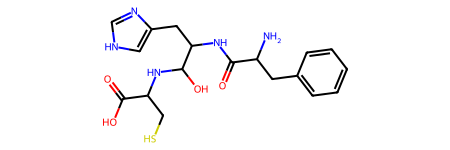

In [16]:
s='NC(CC1=CC=CC=C1)C(=O)NC(CC1=CNC=N1)C(O)NC(CS)C(=O)O'
tri=Chem.MolFromSmiles(s)
display(tri)

Рассчитаем Моргановские фингерпринты для молекулы ибупрофена.

In [17]:
from rdkit.Chem import rdMolDescriptors
import numpy as np

In [18]:
fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(tri, radius=2)
np.array(fp)

array([0, 1, 0, ..., 0, 0, 0])

Моргановский фингерпринт представляет собой вектор из нулей и единиц

С помощью фингерпринтов можно быстро сравнить две молекулы.

0.10054249547920432


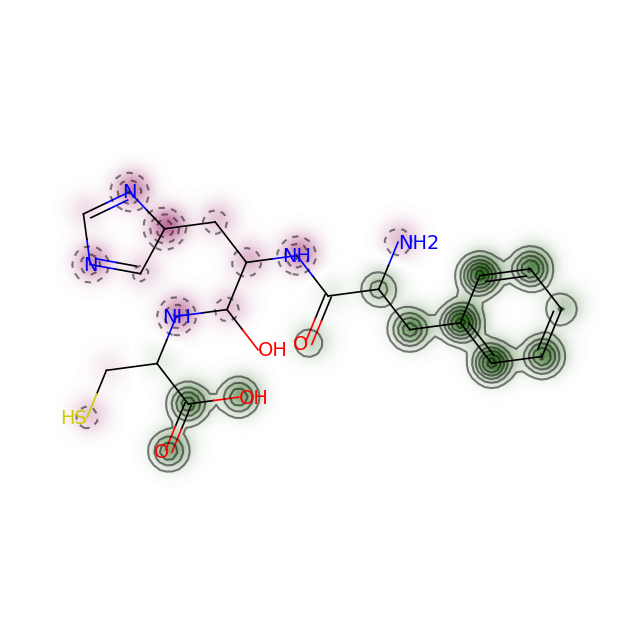

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(ibu, tri, SimilarityMaps.GetMorganFingerprint)
print(maxweight)

## 2. Машинное обучение на молекулярных фингерпринтах

Возьмем датасет BACE, содержащий структуры ингибиторов бета-секретазы человека и величины pIC50, отражающие эффективность ингибирования.

In [27]:
tasks, dataset, transformers = dc.molnet.load_bace_regression() # датасет можно загрузить из библиотеки deepchem
train, valid, test = dataset

train=train.to_dataframe()[['ids','y']]
train['set']='train'
valid=valid.to_dataframe()[['ids','y']]
valid['set']='valid'
test=test.to_dataframe()[['ids','y']]
test['set']='test'
df=pd.concat((train, valid, test)) # переведем датасет в более удобный табличный формат
df

,ids,y,set
0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...,1.065249,train
1,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...,1.173876,train
2,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...,1.173876,train
3,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1.173876,train
4,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1.173876,train
...,...,...,...
147,O=C1N(CCCC1)C(C)(C)[C@@H]1C[C@@H](CCC1)C(=O)N[...,1.621432,test
148,O1c2c(cc(cc2)CC)[C@@H]([NH2+]C[C@@H](O)[C@H]2N...,1.621432,test
149,Fc1c2c(ccc1)[C@@]([NH+]=C2N)(C=1C=C(C)C(=O)N(C...,1.629274,test
150,S(=O)(=O)(CCCCC)C[C@@H](NC(=O)c1cccnc1)C(=O)N[...,1.693472,test


Как мы видимо, в датасете содержатся молекулы в форме smiles (колонка ids) и для каждой молекулы соответствующая ей эффективность ингибирования бета-секретазы (колонка y). Наша задача: создать модель, которая по структуре молекулы предсказывает эффективность ингибирования.

Посмотрим, сколько каких молекул есть в датасете

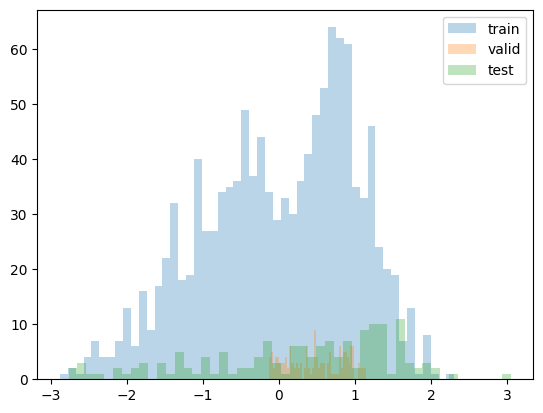

In [50]:
# нарисуем гистограммы распределения данных
plt.hist(df[df.set=='train'].y, bins=50, alpha=0.3, label='train')
plt.hist(df[df.set=='valid'].y, bins=50, alpha=0.3, label='valid')
plt.hist(df[df.set=='test'].y, bins=50, alpha=0.3, label='test')
plt.legend()
plt.show()

Как можно заметить, данные уже разделены на train, valid и test. Первая подвыборка (train) используется для обучения модели, вторая (valid) - для подбора параметров обучения и модели, а третья (test) - для финального тестирования модели.

In [29]:
# добавим в датасет для удобства новый столбец
# c молекулами, переведенными в rdkit формат

df['mols']=train.ids.apply(lambda x: Chem.MolFromSmiles(x))

Большая часть моделей машинного обучения предпочитает работать с векторами и матрицами, поэтому для каждой молекулы посчитаем моргановские фингерпринты и будем обучать модель на них.

In [30]:
s=df.ids.iloc[0]
a=np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),radius=2))
print(s)
print(a)

Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F)F)cc1
[0 1 0 ... 0 0 0]


In [31]:
# напишите функцию для расчета фингерпринтов
def get_fingerprints(mols):

    arr=[] #создаем пустой список
    for mol in tqdm(mols):

        arr.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,radius=2))
        #для каждой молекулы считаем вектор фингерпринтов и дописываем в список

    return np.array(arr) # получаем матрицу, где по 1 оси - молекулы, а по 2 - фингерпринты


Создадим две матрицы фингерпринтов: одну для тренировки модели - из подвыборки train, а другую - для тестирования - из подвыборки valid.

In [32]:
X_train=get_fingerprints(df[df.set=='train'].mols)
X_test=get_fingerprints(df[df.set=='valid'].mols)


100%|██████████| 151/151 [00:00<00:00, 10157.00it/s]


In [33]:
X_train.shape

(1210, 2048)

И создадим два соответствующих вектора с целевой величиной, которую нам предстоит предсказывать

In [34]:
y_train=df[df.set=='train'].y.values
y_test=df[df.set=='valid'].y.values


Прежде чем подбирать модель, посмотрим, насколько хорошо данные разделяются по нашим фингерпринтам. Для этого понизим размерность и визуализируем данные.

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
decomp=pca.fit_transform(X_train)
decomp_test=pca.transform(X_test)

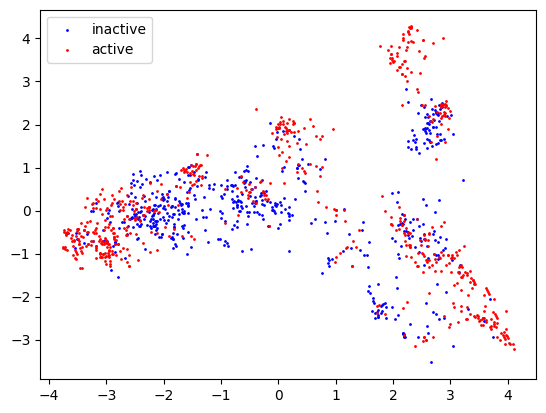

In [36]:
# чтобы облегчить понимание, сделаем допущение,
# что если целевая величина больше 0, то имеет ингибиторную активность,
# а если <0, то не имеет, и покрасим активные и неактивные молекулы в разные цвета

plt.scatter(decomp[y_train<=0,0],decomp[y_train<=0,1], color='blue', s=1, label='inactive')
plt.scatter(decomp[y_train>0,0],decomp[y_train>0,1], color='red', s=1, label='active')
plt.legend()
plt.show()

Как можно заметить, неактивные молекулы на глаз группируются в определенных местах, то есть отделить их от активных будет легко даже для самой простой модели

На всякий случай посмотрим, как разделяются данные для тренировки и для теста

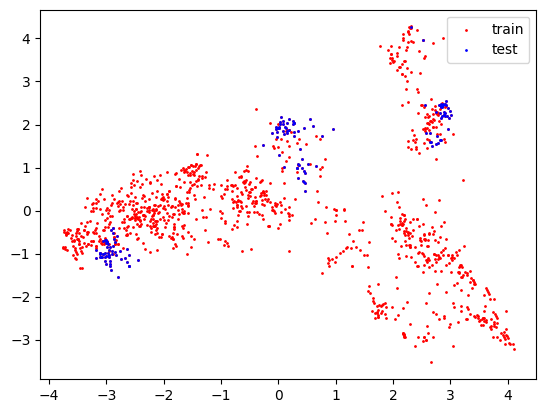

In [37]:
plt.scatter(decomp[:,0],decomp[:,1], color='red', s=1, label='train')
plt.scatter(decomp_test[:,0],decomp_test[:,1], color='blue', s=1, label='test')
plt.legend()
plt.show()

Можно заметить, что тренировочные и тестовые данные распределены по разному, то есть модель с высокой долей вероятности, вне зависимости от того, насколько хорошо она обучилась на тренировочных, на тестовых данных будет работать намного хуже

Теперь приступим к обучению

In [38]:
X_train=sparse.coo_matrix(X_train) # многие модели намного быстрее работают со sparse матрицами
X_test=sparse.coo_matrix(X_test)   # поэтому переведем наши матрицы в sparse формат

Обучим самую простую линейную модель.

In [58]:
from sklearn.linear_model import Ridge

model=Ridge() # инициализируем модель
model.fit(X_train, y_train) # обучим модель

Ridge()

Обученной моделью предскажем ингибиторную активность для тренировочной и тестовой выборки.

In [59]:
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)

Визуализируем результат и посчитаем метрики

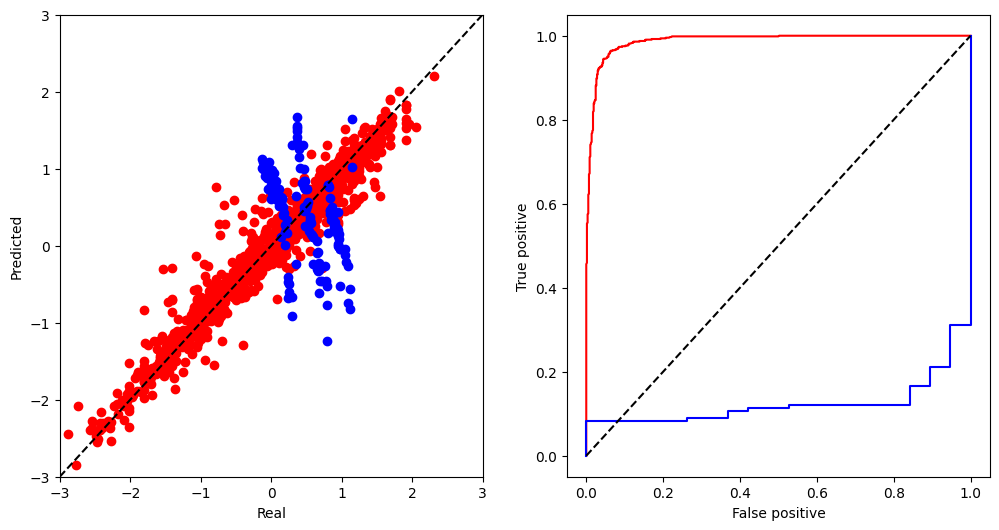

Pearson correlation 
 train: 0.9746086805962684 
 test: -0.4676387089890316
ROC AUC score 
 train: 0.9874671052631578 
 test: 0.12360446570972888


In [61]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(y_train,pred_train, color='red')
plt.scatter(y_test,pred_test,color='blue')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.plot([-3,3],[-3,3], 'k--')


plt.subplot(122)
fpr, tpr, thresholds = roc_curve(y_train>0,pred_train )
plt.plot(fpr, tpr,c='red')
fpr, tpr, thresholds = roc_curve(y_test>0,pred_test )
plt.plot(fpr, tpr,c='blue')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False positive')
plt.ylabel('True positive')

plt.show()

print(f'Pearson correlation \n train: {np.corrcoef(y_train,pred_train)[0,1]} \n test: {np.corrcoef(y_test,pred_test)[0,1]}')
print(f'ROC AUC score \n train: {roc_auc_score(y_train>0,pred_train)} \n test: {roc_auc_score(y_test>0,pred_test)}')



Как мы можем заметить, модель отлично предсказывает те данные, на которых она обучалась, но на тестовых данных ошибается совершенно критично. Это явление называется переобучением и его можно было ожидать, исходя из того, как по разному распределены данные трейна и теста.

## 3. DeepChem и глубокое машинное обучение

Попробуем для той же задачи приспособить графовую конволюционную нейросеть

Данная нейросеть работает с молекулярными структурами, представленными в виде графов, где узлы графа это атомы, а ребра это связи между ними. Поэтому переведем наши данные в графовый формат с помощью функционала deepchem

In [65]:
'''
featurizer=dc.feat.MolGraphConvFeaturizer()
features=featurizer.featurize(df.mols)
'''
# поскольку датасет был взят из deepchem,
# можно не переводить данные в нужный формат,
# а просто загрузить уже преобразованные данные

tasks, dataset, transformers = dc.molnet.load_bace_regression(featurizer=dc.feat.MolGraphConvFeaturizer())
train_set, test_set, _ = dataset

Инициализируем модель

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # если есть возможность, подключим gpu
print(device)

cuda:0


In [66]:
model = dc.models.GCNModel(n_tasks=1,
                           mode='regression', # поскольку мы предсказываем не класс, а конкретное число
                           device=device, # на чем считаем (gpu, cpu)
                           batch_size=10, # сколько молекул подавать в сеть на 1 шаг оптимизации
                           learning_rate=0.0001, # размер шага оптимизации
                           )

Обучим модель

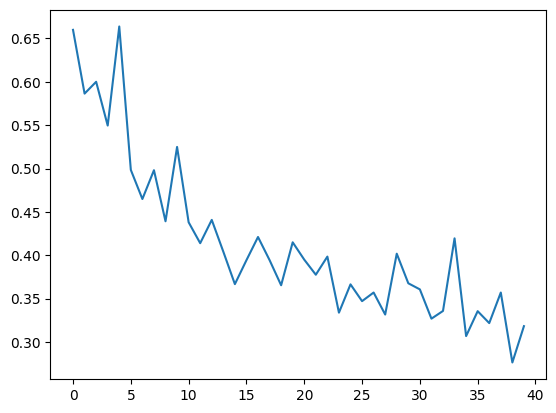

Execution time: 72.05974769592285 sec


In [67]:
time0=time.time()
n_epoch=40 # сколько итераций обучения сделать

# model.fit(train_set, nb_epoch=n_epoch)
# можно написать так, но я хочу отрисовывать кривую обучения,
# поэтому буду обучать через цикл

losses=[]
for i in range(n_epoch):
    losses.append(model.fit(train_set, nb_epoch=1))

    clear_output()
    plt.plot(losses)
    plt.show()

print('Execution time:',time.time()-time0,'sec')


Предскажем результат

In [68]:
pred_train=model.predict(train_set)[:,0]
pred_test=model.predict(test_set)[:,0]

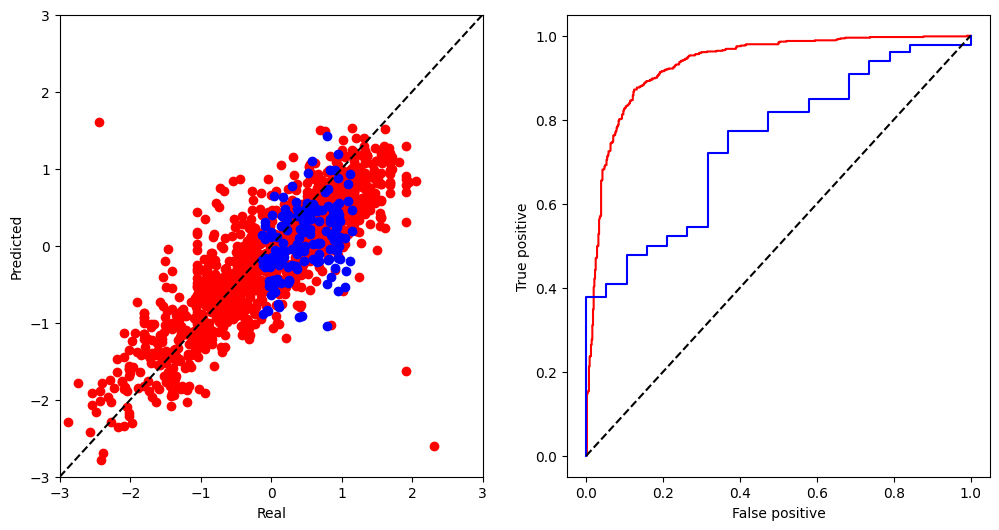

Pearson correlation 
 train: 0.8516110233603303 
 test: 0.36464836335305967
ROC AUC score 
 train: 0.9330071271929826 
 test: 0.746012759170654


In [69]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(y_train,pred_train, color='red')
plt.scatter(y_test,pred_test,color='blue')
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.plot([-3,3],[-3,3], 'k--')


plt.xlabel('Real')
plt.ylabel('Predicted')

plt.subplot(122)
fpr, tpr, thresholds = roc_curve(y_train>0,pred_train)
plt.plot(fpr, tpr,color='red' )
fpr, tpr, thresholds = roc_curve(y_test>0,pred_test)
plt.plot(fpr, tpr,color='blue' )
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False positive')
plt.ylabel('True positive')

plt.show()

print(f'Pearson correlation \n train: {np.corrcoef(y_train,pred_train)[0,1]} \n test: {np.corrcoef(y_test,pred_test)[0,1]}')
print(f'ROC AUC score \n train: {roc_auc_score(y_train>0,pred_train)} \n test: {roc_auc_score(y_test>0,pred_test)}')

Как можно заметить, на тренировочных данных модель работает несколько хуже, но зато не так драматично ошибается на тестовых, то есть переобучение здесь меньше.

## 4. Генерация молекул и MolGAN

Для генерации новых структур молекул существует масса подходов. Разберем один из них, MolGAN.

Генеративные состязательные сети (GAN) состоят из двух модулей: генератора и дискриминатора. Обучение устроено таким образом, что дискриминатор обучается отличать сгенерированные молекулы от существующих молекул из выборки, а генератор учится генерировать наиболее реалистичные молекулы чтобы обмануть дискриминатор.

В архитектуре MolGAN на базе обычной GAN реализовано обучение с подкреплением. Для этого помимо двух вышеописанных модулей в ней имеется еще один модуль награждения (ревард), который обучается предсказывать, насколько сгенерированная модель соответствует некоторым стандартам качества, определяемым сторонними программами (например, rdkit). А генератор, помимо состязания с дискриминатором, теперь еще и учится генерировать наиболее качественные молекулы, чтобы получить поощрение от реварда.

Таким образом, если у пользователя есть готовый алгоритм, определяющий соответствие молекул какому-то условию, он может с помощью MolGAN генерировать молекулы, наиболее полно удовлетворяющие этому условию.

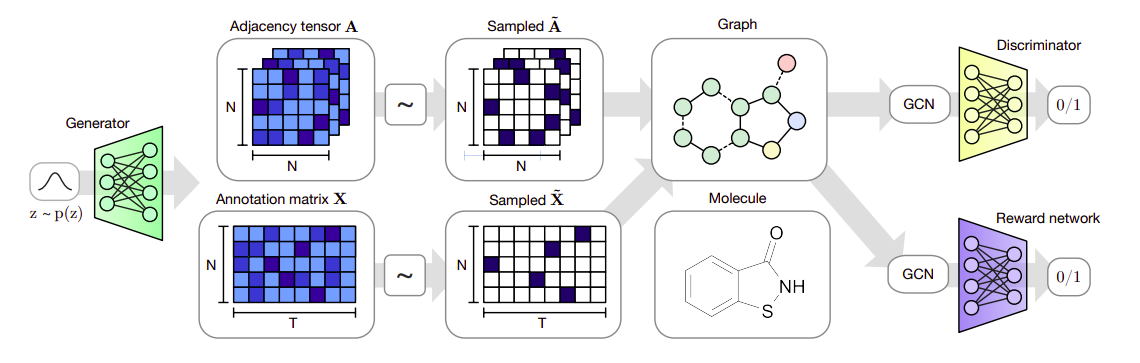

Для начала попробуем обучить MolGAN генерировать реалистичные молекулы на основе нашей выборки

У модели есть ограничения по количеству и типу атомов. Поэтому определим, какие размеры молекул и типы атомов наиболее часто представлены в нашей выборке и ограничим модель исходя из этой информации

Задание: посчитайте какие атомы в каком количестве представлены в датасете и постройте барплот. Нарисуйте гистограмму распределения количества атомов в молекулах.

<BarContainer object of 8 artists>

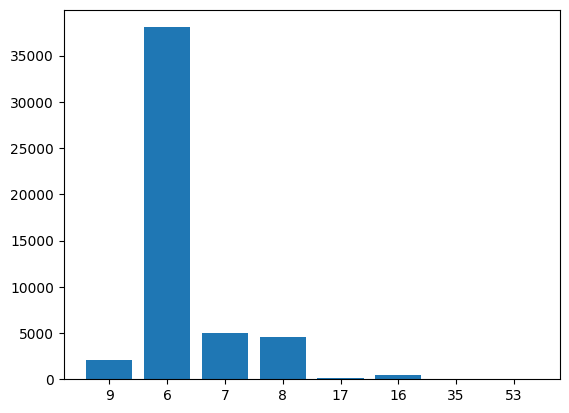

In [70]:
atom_dict={}
for mol in df.mols:
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() in atom_dict:
            atom_dict[atom.GetAtomicNum()]+=1
        else:
            atom_dict[atom.GetAtomicNum()]=1
plt.bar([str(x) for x in atom_dict.keys()], atom_dict.values())

In [72]:
atom_dict

{9: 2134, 6: 38052, 7: 4982, 8: 4531, 17: 187, 16: 501, 35: 64, 53: 8}

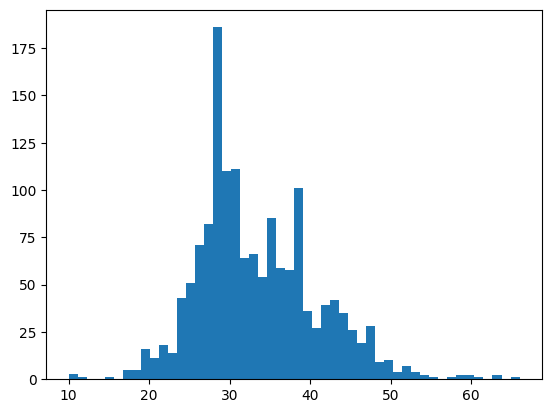

In [71]:
plt.hist([x.GetNumAtoms() for x in df.mols], bins=50)
plt.show()

Установим порог количества атомов в молекуле и определим типы атомов, которые будут использоваться при обучении и генерации.

In [82]:
# что чем больше порог и количество типов атомов, тем нестабильнее будет работать сеть
num_atoms=40
atom_labels=[0, 6, 7, 8, 9, 16, 17, 35, 53]

### 4.1. ---


In [ ]:
# это код для обучения и запуска MolGAN из deepchem
# не советую его использовать
'''
import logging
logging.getLogger("deepchem.feat.base_classes").setLevel(logging.ERROR)

gan_featurizer = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=atom_labels)

time0=time.time()
X=gan_featurizer.featurize(df.mols) # get featurized moleculss
print('Execution time:',time.time()-time0,'sec')

filter=[] # filter unfeaturized molecules
for i in X:
    if not isinstance(i,dc.feat.molecule_featurizers.molgan_featurizer.GraphMatrix):
        filter.append(False)
    elif len(i.node_features)!=num_atoms:
        filter.append(False)
    else:
        filter.append(True)
filter=np.array(filter)
print('Featurized:',sum(filter))
print('Skipped:',sum(filter==False))
X=X[filter]

from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from tensorflow import one_hot

model = MolGAN(learning_rate=0.0001, vertices=num_atoms, device=device, batch_size=128)

dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in X],[x.node_features for x in X])

def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=model.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], model.edges)
            node_tensor = one_hot(batch[1], model.nodes)
            yield {model.data_inputs[0]: adjacency_tensor, model.data_inputs[1]:node_tensor}

time0=time.time()
model.fit_gan(iterbatches(10), generator_steps=1, checkpoint_interval=1000) # train model
print('Execution time:',time.time()-time0,'sec')

generated_data = model.predict_gan_generator(1000) # generate samples
gen_mols = gan_featurizer.defeaturize(generated_data)

'''

### 4.2. Импорты

In [79]:
# запретим rdkit выдавать логи, а то их слишком много
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# заодно уберем варнинги, а то их тоже много
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Скачаем оригинальный репозиторий https://github.com/nicola-decao/MolGAN.git

In [ ]:
!git clone https://github.com/nicola-decao/MolGAN.git
!tf_upgrade_v2 --intree MolGAN/ --outtree MolGAN_v2/ --reportfile report.txt
!mkdir data
!wget https://github.com/gablg1/ORGAN/raw/master/organ/NP_score.pkl.gz -O data/NP_score.pkl.gz
!wget https://github.com/gablg1/ORGAN/raw/master/organ/SA_score.pkl.gz -O data/SA_score.pkl.gz


In [75]:
import sys
import tensorflow as tf
sys.path.append("MolGAN_v2")
tf.compat.v1.disable_eager_execution()


В репозитории есть файл example.py с запуском обучения. Скопируем код с небольшими модификациями

In [76]:
# from https://github.com/nicola-decao/MolGAN/blob/master/example.py

from MolGAN_v2.utils.sparse_molecular_dataset import SparseMolecularDataset
from MolGAN_v2.utils.trainer import Trainer
from MolGAN_v2.utils.utils import *
from MolGAN_v2.models.gan import GraphGANModel
from MolGAN_v2.models import encoder_rgcn, decoder_adj, decoder_dot, decoder_rnn

from MolGAN_v2.optimizers.gan import GraphGANOptimizer


### 4.3. Инициализация модели

Определим гиперпараметры. От того, насколько хорошо мы их подобрали, будет зависеть, научится ли сеть генерировать хоть что-то осмысленное

In [88]:
# гиперпараметры

batch_dim = 32 # кол-во элементов выборки на шаг оптимизации
lr=1e-3 # размер шага оптимизации

la = 1 # отношение lr дискриминаторов к lr генератора
n_critic = 5 # кол-во шагов оптимизации генератора на шаг оптимизации реварда
n_samples = 5000 # кол-во генерируемых образцов для reward

decoder_units=(128, 256, 512, 1024) # размер и количество слоев в декодере
discriminator_units=((256, 128), 128, (256, 128)) # размер и кол-во слоев в дискриминаторах

z_dim = 8 # размер входного случайного вектора
dropout = 0 # зашумление данных
epochs = 300 # кол-во итераций обучения


Местные модули читают вещества в виде SMILES из файла, поэтому сначала запишем их туда

In [77]:
with open('assay.smi','w') as f:
    for line in df.ids:
        f.write(line+'\n')

Загрузим нашу выборку в датасет, фильтруя молекулы по количеству и типу атомов

In [ ]:
data = SparseMolecularDataset()

data.generate('assay.smi', filters=lambda x: x.GetNumAtoms() <= num_atoms and
                                              all((k.GetAtomicNum() in atom_labels) for k in x.GetAtoms()))
data.save('assay.sparsedataset')

# Можно еще скачать другой датасет
# Там больше веществ
# (источник https://pubchem.ncbi.nlm.nih.gov/bioassay/1706)

#!gdown --id 1eI6evkdhGUmqlxUBe66itBmdzitmMqkf
#data.load('assay.sparsedataset')


Следующая функция используется для расчета rewards. Для каждой сгенерированной молекулы она считает различные метрики, такие как sas (доступность для растворителя), np (естественность), qed (похожесть на лекарство), logp (коэфф. распределения между октанолом и водой) и тому подобные. Модель обучается генерировать молекулы таким образом чтобы максимизировать значения этих метрик  

In [84]:
metric = 'logp,sas,qed,unique' # будем считать только эти 4

def reward(mols):
    rr = 1.
    for m in metric.split(','):

        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        elif m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        elif m == 'dc':
            rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))

    return rr.reshape(-1, 1)

Вспомогательные функции для загрузки данных в модель

In [89]:
steps = (len(data) // batch_dim)


def train_fetch_dict(i, steps, epoch, epochs, min_epochs, model, optimizer):
    a = [optimizer.train_step_G] if i % n_critic == 0 else [optimizer.train_step_D]
    b = [optimizer.train_step_V] if i % n_critic == 0 and la < 1 else []
    return a + b


def train_feed_dict(i, steps, epoch, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_train_batch(batch_dim)
    embeddings = model.sample_z(batch_dim)

    if la < 1:

        if i % n_critic == 0:
            rewardR = reward(mols)

            n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                               feed_dict={model.training: False, model.embeddings: embeddings})
            n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
            mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

            rewardF = reward(mols)

            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.rewardR: rewardR,
                         model.rewardF: rewardF,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}

        else:
            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}
    else:
        feed_dict = {model.edges_labels: a,
                     model.nodes_labels: x,
                     model.embeddings: embeddings,
                     model.training: True,
                     model.dropout_rate: dropout,
                     optimizer.la: 1.0}

    return feed_dict


def eval_fetch_dict(i, epochs, min_epochs, model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def eval_feed_dict(i, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_validation_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


def test_fetch_dict(model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def test_feed_dict(model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_test_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict

def _eval_update(i, epochs, min_epochs, model, optimizer, batch_dim, eval_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


def _test_update(model, optimizer, batch_dim, test_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0

Инициализация модели, оптимизаторов итп.

In [90]:
tf.compat.v1.reset_default_graph()

model = GraphGANModel(data.vertexes,
                      data.bond_num_types,
                      data.atom_num_types,
                      z_dim,
                      decoder_units=decoder_units,
                      discriminator_units=discriminator_units,
                      decoder=decoder_adj,
                      discriminator=encoder_rgcn,
                      soft_gumbel_softmax=False,
                      hard_gumbel_softmax=False,
                      batch_discriminator=False)

# optimizer
optimizer = GraphGANOptimizer(model, learning_rate=lr, feature_matching=False)

# session
session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                               log_device_placement=True))
session.run(tf.compat.v1.global_variables_initializer())

# trainer
trainer = Trainer(model, optimizer, session)

print('Parameters: {}'.format(np.sum([np.prod(e.shape) for e in session.run(tf.compat.v1.trainable_variables())])))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Parameters: 9828906


### 4.4. Обучение модели

Запуск обучения

In [ ]:
# model
with tf.compat.v1.device('/device:GPU:0'):

    trainer.train(batch_dim=batch_dim,
              epochs=epochs,
              steps=steps,
              train_fetch_dict=train_fetch_dict,
              train_feed_dict=train_feed_dict,
              eval_fetch_dict=eval_fetch_dict,
              eval_feed_dict=eval_feed_dict,
              test_fetch_dict=test_fetch_dict,
              test_feed_dict=test_feed_dict,
              save_every=1,
              directory='data', # here users need to first create and then specify a folder where to save the model
              _eval_update=_eval_update,
              _test_update=_test_update)

Правила обучения MolGAN: loss должны уменьшаться, score должны расти.

Сгенерируем некоторое количество структур и выведем их

In [92]:
# функции для генерации структур и их конвертации в нужный формат
# это немного модифицированная функция из MolGAN.utils.utils
# в оригинальной функции не было удаления паддингов,
# поэтому пришлось ее немного переписать

def my_samples(data, model, session, embeddings, sample=False):
    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax] if sample else [
        model.nodes_argmax, model.edges_argmax], feed_dict={
        model.embeddings: embeddings, model.training: False})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)

    mols = [my_matrices2mol(data, n_, e_, strict=True) for n_, e_ in zip(n, e)]

    return mols

def my_matrices2mol(data, node_labels, edge_labels, strict=False):
        mol = Chem.RWMol()

        val_atoms=node_labels!=0

        if val_atoms.shape[0]==0:
            return None

        node_labels=node_labels[val_atoms]
        edge_labels=edge_labels[val_atoms,:]
        edge_labels=edge_labels[:, val_atoms]


        for node_label in node_labels:
            mol.AddAtom(Chem.Atom(data.atom_decoder_m[node_label]))

        for start, end in zip(*np.nonzero(edge_labels)):
            if start > end:
                mol.AddBond(int(start), int(end), data.bond_decoder_m[edge_labels[start, end]])

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol



Сгенерируем структуры. Скорее всего, они в основном получатся совсем невалидными, так что лучше перезапускать несколько раз

In [ ]:
# gen_mols=samples(data, model, session, model.sample_z(1), sample=True ) встроенная функция из MolGAN.utils.utils, которая мне не нравится

gen_mols=my_samples(data, model, session, model.sample_z(1), sample=True ) # генерируем структуры

gen_mols=[x for x in gen_mols if x!=None and Chem.Descriptors.HeavyAtomMolWt(x)>0] # фильтруем невалидные

len(gen_mols) # сколько осталось

In [ ]:
mols2grid_image(gen_mols,5) # рисуем структуры

## 5. Домашнее задание

1. Подберите и обучите простую модель из https://scikit-learn.org/stable/supervised_learning.html на данных BACE чтобы улучшить результат, полученный на уроке

2. Полученную в п. 1 модель используйте для расчета поощрений в MolGAN. Для этого модифицируйте функцию reward

3. Подберите гиперпараметры чтобы MolGAN заработал нормально (по желанию). Можно попробовать обучать подольше.